잘 안되는 거임

데이터셋 로드 완료
데이터셋 분할 완료


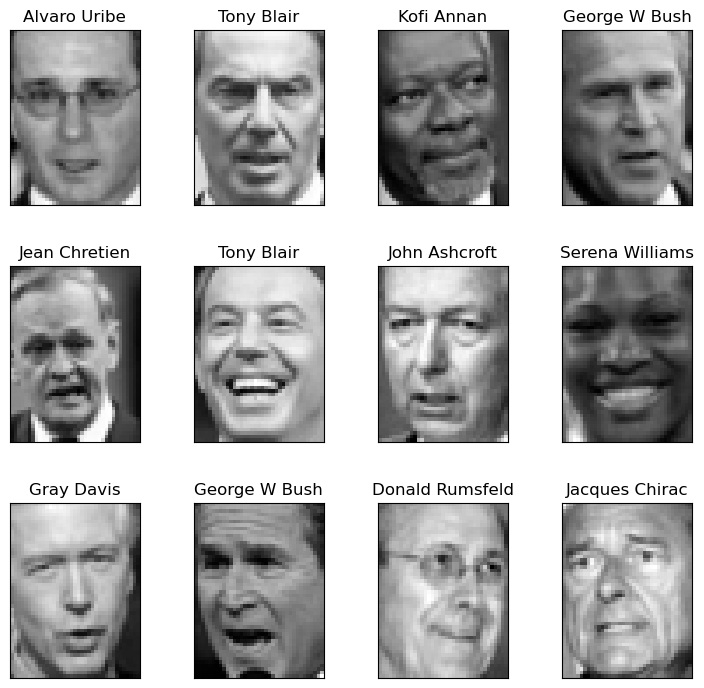

학습중
Stage 1 accuracy: 0.09
Stage 1 remaining training samples: 3459
Stage 2 accuracy: 0.11
Stage 2 remaining training samples: 3459
Stage 3 accuracy: 0.11
Stage 3 remaining training samples: 3459


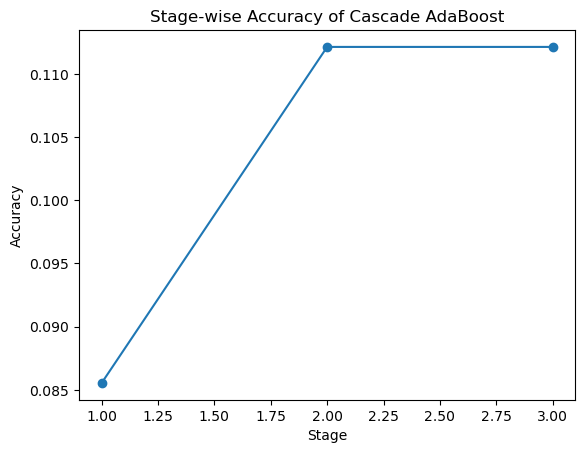

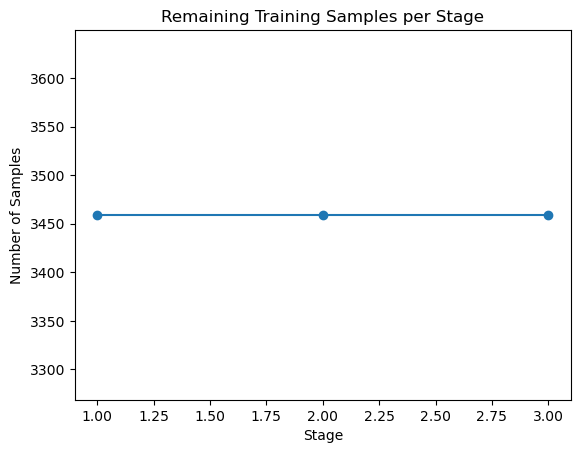

Cascade AdaBoost Accuracy: 0.10


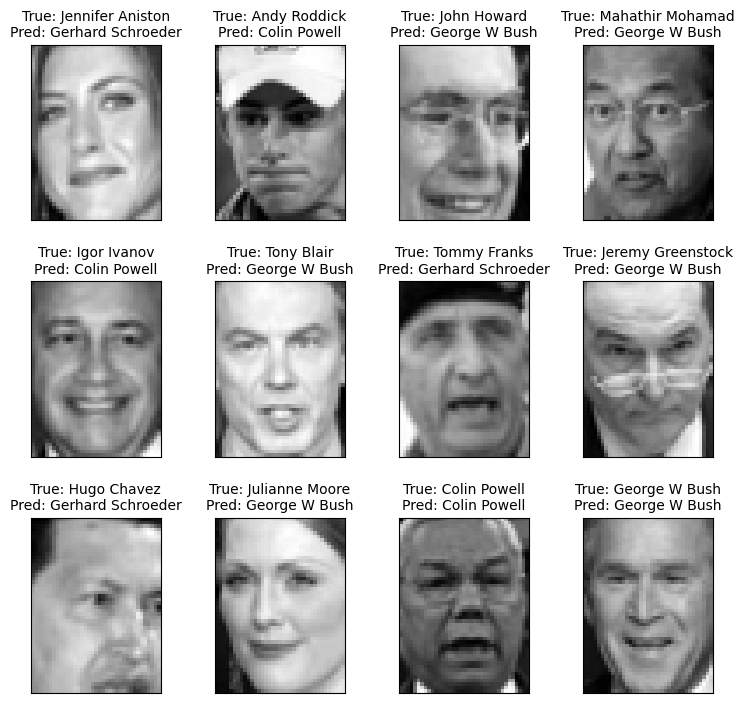

In [3]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 얼굴 데이터셋 로드
faces = fetch_lfw_people(min_faces_per_person=10, resize=0.4)
X = faces.data
y = faces.target
n_samples, h, w = faces.images.shape
target_names = faces.target_names

print("데이터셋 로드 완료")

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("데이터셋 분할 완료")

# 일부 이미지 시각화
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# 예시 이미지 시각화
plot_gallery(X_train, [target_names[y] for y in y_train], h, w)
plt.show()

print("학습중")

# 단계별 학습
base_estimator = DecisionTreeClassifier(max_depth=1)
cascade_stages = []
stage_accuracies = []
stage_train_sizes = []

# 샘플 가중치 초기화
sample_weights = np.ones(X_train.shape[0])

for stage in range(3):
    model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42, algorithm='SAMME')
    model.fit(X_train, y_train, sample_weight=sample_weights)
    cascade_stages.append(model)
    stage_accuracy = accuracy_score(y_test, model.predict(X_test))
    stage_accuracies.append(stage_accuracy)
    stage_train_sizes.append(X_train.shape[0])
    print(f'Stage {stage + 1} accuracy: {stage_accuracy:.2f}')
    print(f'Stage {stage + 1} remaining training samples: {X_train.shape[0]}')

    # 잘못 분류된 샘플의 가중치 증가
    incorrect = model.predict(X_train) != y_train
    sample_weights[incorrect] *= 1.5  # 가중치를 1.5배 증가

    # 가중치 재조정 (정규화)
    sample_weights /= sample_weights.sum()

    # 일부 샘플에 잡음 추가
    noise_factor = 0 # 잡음의 세기
    noise_indices = np.random.choice(len(X_train), size=int(0.1 * len(X_train)), replace=False)
    X_train[noise_indices] += noise_factor * np.random.normal(size=X_train[noise_indices].shape)

# 학습 단계별 정확도 시각화
plt.figure()
plt.plot(range(1, 4), stage_accuracies, marker='o')
plt.title('Stage-wise Accuracy of Cascade AdaBoost')
plt.xlabel('Stage')
plt.ylabel('Accuracy')
plt.show()

# 학습 단계별 남은 데이터 샘플 수 시각화
plt.figure()
plt.plot(range(1, 4), stage_train_sizes, marker='o')
plt.title('Remaining Training Samples per Stage')
plt.xlabel('Stage')
plt.ylabel('Number of Samples')
plt.show()

# 최종 검출
weighted_votes = np.zeros((X_test.shape[0], len(np.unique(y_test))))

for model in cascade_stages:
    predictions = model.predict(X_test)
    for i in range(len(predictions)):
        weighted_votes[i, predictions[i]] += model.estimator_weights_.sum()

final_predictions = np.argmax(weighted_votes, axis=1)

accuracy = accuracy_score(y_test, final_predictions)
print(f'Cascade AdaBoost Accuracy: {accuracy:.2f}')

# 예측 결과 시각화
def plot_predictions(images, true_labels, pred_labels, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        title = f'True: {target_names[true_labels[i]]}\nPred: {target_names[pred_labels[i]]}'
        plt.title(title, size=10)
        plt.xticks(())
        plt.yticks(())

# 예측 결과 시각화
plot_predictions(X_test, y_test, final_predictions, h, w)
plt.show()
